# Proyek Klasifikasi Gambar: Klasifikasi Angka Tulisan Tangan
- **Nama:** Andi Sadapotto
- **Email:** andi.sadapotto.m@gmail.com

## Import Semua Packages/Library yang Digunakan

In [39]:
!pip install tensorflow==2.15

In [40]:
import tensorflow as tf
import random
import seaborn as sns
import pandas as pd
import shutil
import numpy as np
import os

from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split


## Data Preparation

### Data Loading

In [41]:
%pip install kaggle

In [42]:
# %mkdir ~/.kaggle
# %cp kaggle.json ~/.kaggle/

# %chmod 600 ~/.kaggle/kaggle.json

In [43]:
# download dataset
!kaggle datasets download -d olafkrastovski/handwritten-digits-0-9

Dataset URL: https://www.kaggle.com/datasets/olafkrastovski/handwritten-digits-0-9
License(s): CC0-1.0
handwritten-digits-0-9.zip: Skipping, found more recently modified local copy (use --force to force download)


In [44]:
dataset_dir = "dataset"

In [45]:
!rm -rf dataset
!rm -rf dataset_resize

In [46]:
# ekstrak
import os

os.makedirs(dataset_dir, exist_ok=True)
!unzip handwritten-digits-0-9 -d dataset

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: dataset/7/Seven_full (2094).jpg  
  inflating: dataset/7/Seven_full (2095).jpg  
  inflating: dataset/7/Seven_full (2096).jpg  
  inflating: dataset/7/Seven_full (2097).jpg  
  inflating: dataset/7/Seven_full (2098).jpg  
  inflating: dataset/7/Seven_full (2099).jpg  
  inflating: dataset/7/Seven_full (21).jpg  
  inflating: dataset/7/Seven_full (210).jpg  
  inflating: dataset/7/Seven_full (2100).jpg  
  inflating: dataset/7/Seven_full (2101).jpg  
  inflating: dataset/7/Seven_full (2102).jpg  
  inflating: dataset/7/Seven_full (2103).jpg  
  inflating: dataset/7/Seven_full (2104).jpg  
  inflating: dataset/7/Seven_full (2105).jpg  
  inflating: dataset/7/Seven_full (2106).jpg  
  inflating: dataset/7/Seven_full (2107).jpg  
  inflating: dataset/7/Seven_full (2108).jpg  
  inflating: dataset/7/Seven_full (2109).jpg  
  inflating: dataset/7/Seven_full (211).jpg  
  inflating: dataset/7/Seven_full (2110).jpg  
  inf

### Data Exploration

In [47]:
def count_images_per_class(folder):
    class_counts = {}  # Dictionary to store the count of images by class

    # Iterate through each class directory
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)  # Path to the class folder

        if os.path.isdir(class_path):  # Check if it is a directory
            class_images = os.listdir(class_path)  # List all images in the class folder
            class_counts[class_name] = len(class_images)  # Count the images in the class

    return class_counts  # Return the count of images by class


# Count the images in each class
image_counts = count_images_per_class(dataset_dir)

# Print the counts
total_images = 0
for class_name, count in image_counts.items():
    print(f"Class '{class_name}' has {count} images.")
    total_images +=count
print(f'Total images {total_images}')

Class '3' has 2202 images.
Class '2' has 2233 images.
Class '7' has 2116 images.
Class '8' has 2085 images.
Class '9' has 2016 images.
Class '6' has 2121 images.
Class '0' has 2236 images.
Class '1' has 2241 images.
Class '5' has 2126 images.
Class '4' has 2179 images.
Total images 21555


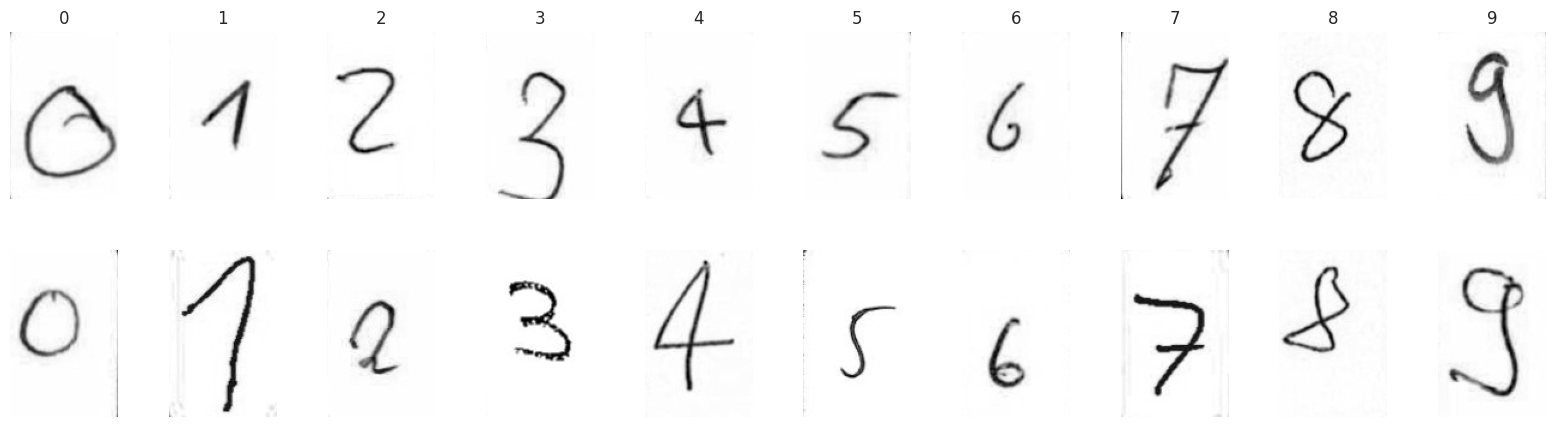

In [48]:
# Fungsi untuk load images dari folder dataset
def load_images_from_folder(folder: str, images_per_class=2) -> dict:
    images = {}  # Dictionary untuk menyimpan images berdasarkan class

    # Lakukan perulangan di setiap direktory class
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)  # Path untuk folder class

        if os.path.isdir(class_path):  # Cek value class_path apakah merupakan direktori
            class_images = os.listdir(class_path)  # List semua gambar di folder class
            random.shuffle(class_images)  # Mengacak gambar
            # Buka gambar sebanyak images_per_class yang spesifik dan simpan di dic images
            images[class_name] = [Image.open(os.path.join(class_path, img)).convert('L') for img in class_images[:images_per_class]]

    return images  # Return images dict

# Fungsi untuk plot image dalam sebuah grid
def plot_images(images_dict: dict, images_per_class=2):
    classes = sorted(images_dict.keys())  # get list nama kelas yang telah di urutkan
    ncols, nrows = len(classes), images_per_class  # Set jumlah kolom dan baris untuk plot
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5))  # Create  figure dengan subplots
    fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust space antara plots

    for col, class_name in enumerate(classes):  # Lakukan iterasi untuk setiap class
        for row in range(nrows):  # Lakukan iterasi pada jumlah gambar per class
            axes[row, col].imshow(images_dict[class_name][row], cmap="gray")  # Tampilkan gambar
            axes[row, col].axis('off')  # Hide axis
            if row == 0:  # Only add a title to the top row Set title hanya pada baris paling atas
                axes[row, col].set_title(class_name)  # Set title

    plt.show()  # Tampilkan plot

# Load the images
images_dict = load_images_from_folder(dataset_dir, images_per_class=2)

# Plot the images
plot_images(images_dict)  # Call the function to plot the images

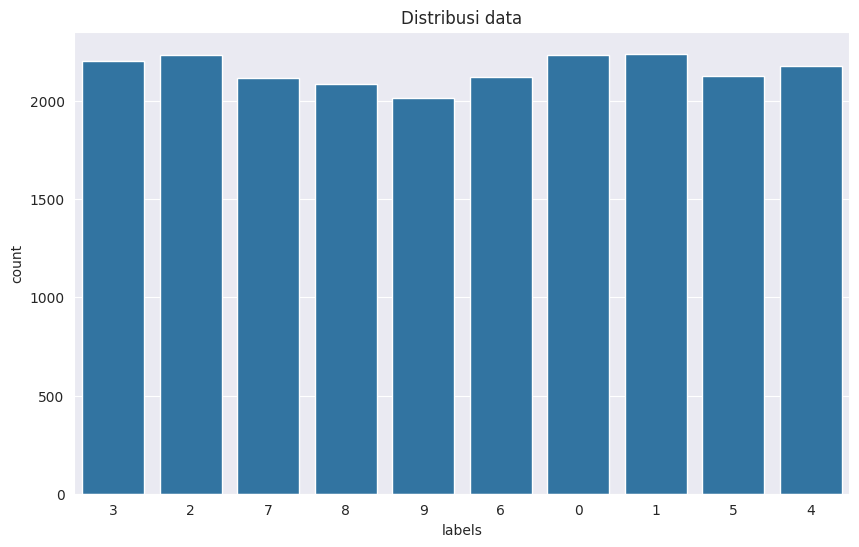

In [49]:
def get_image_paths_and_labels(folder: str):
    image_paths = []
    labels = []
    file_name = []


    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)

        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                image_paths.append(image_path)
                labels.append(class_name)
                file_name.append(image_name)


    return image_paths, labels, file_name

image_path, labels, file_name = get_image_paths_and_labels(dataset_dir)

distribution_train = pd.DataFrame({"path":image_path, 'file_name':file_name, "labels":labels})
# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (10,6))
plt.title(label="Distribusi data")
sns.set_style("darkgrid")
plot_data = sns.countplot(data=distribution_train, x=Label)

### Data Preprocessing

#### Preprocessing

In [50]:
# random resize image
def resize_image(image_path, output_path, size):
    with Image.open(image_path) as img:
        img = img.resize(size, Image.ANTIALIAS)
        img.save(output_path)

In [51]:
def process_class_folder(class_folder, output_class_folder, min_size, max_size):
    if not os.path.exists(output_class_folder):
        os.makedirs(output_class_folder)

    for filename in os.listdir(class_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(class_folder, filename)
            output_path = os.path.join(output_class_folder, filename)

            width = random.randint(min_size[0], max_size[0])
            height = random.randint(min_size[1], max_size[1])

            resize_image(image_path, output_path, (width, height))
            print(f'Resized {filename} to {width}x{height}')

def process_dataset(input_folder, output_folder, min_size, max_size):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for class_name in os.listdir(input_folder):
        class_folder = os.path.join(input_folder, class_name)
        output_class_folder = os.path.join(output_folder, class_name)

        if os.path.isdir(class_folder):
            process_class_folder(class_folder, output_class_folder, min_size, max_size)

In [52]:
input_folder = 'dataset'
output_folder = 'dataset_resize'
min_size = (50, 50)  # Minimum width and height
max_size = (300, 300)  # Maximum width and height

process_dataset(input_folder, output_folder, min_size, max_size)

<ipython-input-50-c653da087962>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(size, Image.ANTIALIAS)


Output streaming akan dipotong hingga 5000 baris terakhir.
Resized One_full (371).jpg to 125x136
Resized One_full (876).jpg to 253x76
Resized One_full (123).jpg to 130x108
Resized One_full (1209).jpg to 60x213
Resized One_full (1800).jpg to 166x215
Resized One_full (1724).jpg to 88x185
Resized One_full (1931).jpg to 200x272
Resized One_full (1151).jpg to 190x86
Resized One_full (1169).jpg to 214x109
Resized One_full (1568).jpg to 264x247
Resized One_full (1855).jpg to 78x263
Resized One_full (345).jpg to 179x177
Resized One_full (2053).jpg to 185x261
Resized One_full (590).jpg to 56x150
Resized One_full (2155).jpg to 156x225
Resized One_full (1650).jpg to 51x294
Resized One_full (721).jpg to 173x65
Resized One_full (637).jpg to 108x294
Resized One_full (1254).jpg to 161x53
Resized One_full (1763).jpg to 232x230
Resized One_full (148).jpg to 215x172
Resized One_full (1486).jpg to 79x253
Resized One_full (2157).jpg to 298x232
Resized One_full (605).jpg to 83x294
Resized One_full (25).jpg

In [53]:
# show image resolution
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")
print_images_resolution(output_folder)

Output streaming akan dipotong hingga 5000 baris terakhir.
- (273, 239)
- (111, 177)
- (185, 126)
- (97, 242)
- (231, 242)
- (157, 64)
- (284, 105)
- (229, 169)
- (143, 129)
- (215, 234)
- (248, 182)
- (124, 116)
- (289, 183)
- (113, 223)
- (60, 131)
- (132, 236)
- (206, 185)
- (118, 72)
- (200, 111)
- (233, 59)
- (269, 241)
- (117, 113)
- (236, 64)
- (227, 244)
- (268, 245)
- (134, 53)
- (92, 285)
- (166, 234)
- (240, 183)
- (245, 298)
- (97, 134)
- (157, 185)
- (243, 188)
- (196, 113)
- (55, 137)
- (275, 177)
- (228, 65)
- (173, 129)
- (99, 180)
- (233, 180)
- (186, 68)
- (117, 234)
- (249, 124)
- (194, 188)
- (180, 290)
- (87, 62)
- (106, 75)
- (152, 191)
- (97, 255)
- (205, 54)
- (69, 193)
- (251, 170)
- (210, 132)
- (143, 142)
- (289, 196)
- (230, 270)
- (242, 121)
- (154, 237)
- (173, 250)
- (140, 73)
- (71, 239)
- (184, 116)
- (277, 78)
- (134, 295)
- (175, 296)
- (122, 204)
- (216, 68)
- (276, 119)
- (59, 121)
- (119, 135)
- (279, 124)
- (224, 188)
- (298, 137)
- (243, 201)
- (

#### Split Dataset

In [54]:

# Function to move images to the new directory structure
def move_images(image_paths, labels, base_dir):
    for image_path, label in zip(image_paths, labels):
        class_dir = os.path.join(base_dir, label)

        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        shutil.copy(image_path, class_dir)

# Split into training+validation (80%) and testing sets (20%)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(image_path, labels, test_size=0.2, stratify=labels, random_state=300)

# Split training+validation into training (80%) and validation (20%)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_val_paths, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=300)

# Move the images to train, val, and test directories
train_dir = "dataset_resize/train/" # use for training
val_dir = "dataset_resize/val/" # use for training validation
test_dir = "dataset_resize/test/" # use for testing
# Note : saya buat langsung 3 split train, valid, test dengan skema 80:20 train test
#kemudian 80:20 lagi train validation, krna ujung"nya kan seperti itu juga dan pada saat normalisasi (imagegenerator) tidak lagi di split


In [55]:
# Ensure the directories exist
for directory in [train_dir, val_dir,test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Move training images
move_images(train_paths, train_labels, train_dir)

# # Move validation images
move_images(val_paths, val_labels, val_dir)

# Move testing images
move_images(test_paths, test_labels, test_dir)

print("Dataset has been split and images have been moved.")

Dataset has been split and images have been moved.


In [56]:
# count images each train, val, test folder
train_dir_count = count_images_per_class(train_dir)
val_dir_count = count_images_per_class(val_dir)
test_dir_count = count_images_per_class(test_dir)

total_images = 0
total_images_train=0
total_images_test=0
total_images_val=0
for class_name, count in train_dir_count.items():
    total_images +=count
    total_images_train+=count
print(f'Total images {total_images_train} on {train_dir}')

for class_name, count in val_dir_count.items():
    total_images +=count
    total_images_val+=count
print(f'Total images {total_images_val} on {val_dir}')

for class_name, count in test_dir_count.items():
    total_images +=count
    total_images_test+=count
print(f'Total images {total_images_test} on {test_dir}')
# Note : saya buat langsung 3 split train, valid, test dengan skema 80:20 train+valid test
#kemudian 80:20 lagi train validation, krna ujung"nya kan seperti itu juga dan pada saat normalisasi (imagegenerator) tidak lagi di split

Total images 13795 on dataset_resize/train/
Total images 3449 on dataset_resize/val/
Total images 4311 on dataset_resize/test/


In [57]:
# dataset normalisation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,  # Randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # Randomly translate images horizontally (fraction of total width)
        height_shift_range=0.2,  # Randomly translate images vertically (fraction of total height)
        # shear_range=0.1,  # Randomly apply shearing transformations
        # zoom_range=0.1,  # Randomly zoom in/out on images
        # horizontal_flip=True,  # Randomly flip images horizontally
        # fill_mode='nearest',  # Fill in new pixels created by the transformations
        # validation_split = 0.2,
    )
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(train_dir,
                                              batch_size=32,
                                              target_size=(90,140),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              # subset='training',
                                              shuffle=True)

validation_generator = val_datagen.flow_from_directory(val_dir,
                                                   batch_size=32,
                                                   target_size=(90,140),
                                                   color_mode="grayscale",
                                                   class_mode='categorical',
                                                  #  subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(90,140),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 13795 images belonging to 10 classes.
Found 3449 images belonging to 10 classes.
Found 4311 images belonging to 10 classes.


## Modelling

In [58]:
# init model
input_shape = (90, 140, 1)
num_class = 10
model = tf.keras.models.Sequential([
    # first convolution
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # second convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # third convolution
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.3),

    # output
    tf.keras.layers.Dense(num_class, activation="softmax")

])

In [59]:
# compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              # loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 88, 138, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 44, 69, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 42, 67, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 21, 33, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 31, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 9, 15, 128)       

In [61]:
# create callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True
)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, mode='min', verbose=1)

In [ ]:
# Extract data and labels from generator
data, labels = [], []
for _ in range(len(data_gen)):
    x, y = data_gen.next()
    data.append(x)
    labels.append(y)

data = np.concatenate(data)
labels = np.concatenate(labels)

In [ ]:
from sklearn.model_selection import KFold

In [62]:
# Fit the model

history = model.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    callbacks=[early_stopping_callback, model_checkpoint_callback, reduce_lr_callback]
)

Epoch 1/30
432/432 [==============================] - 32s 71ms/step - loss: 1.8924 - accuracy: 0.3187 - val_loss: 0.8176 - val_accuracy: 0.7463 - lr: 0.0010
Epoch 2/30
432/432 [==============================] - 28s 65ms/step - loss: 0.8146 - accuracy: 0.7390 - val_loss: 0.3225 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 3/30
432/432 [==============================] - 28s 66ms/step - loss: 0.5531 - accuracy: 0.8286 - val_loss: 0.1878 - val_accuracy: 0.9472 - lr: 0.0010
Epoch 4/30
432/432 [==============================] - 29s 66ms/step - loss: 0.4267 - accuracy: 0.8647 - val_loss: 0.1616 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 5/30
432/432 [==============================] - 28s 65ms/step - loss: 0.3662 - accuracy: 0.8832 - val_loss: 0.1535 - val_accuracy: 0.9551 - lr: 0.0010
Epoch 6/30
432/432 [==============================] - 28s 65ms/step - loss: 0.3142 - accuracy: 0.9024 - val_loss: 0.1312 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 7/30
432/432 [==============================] - 28s 

## Evaluasi dan Visualisasi

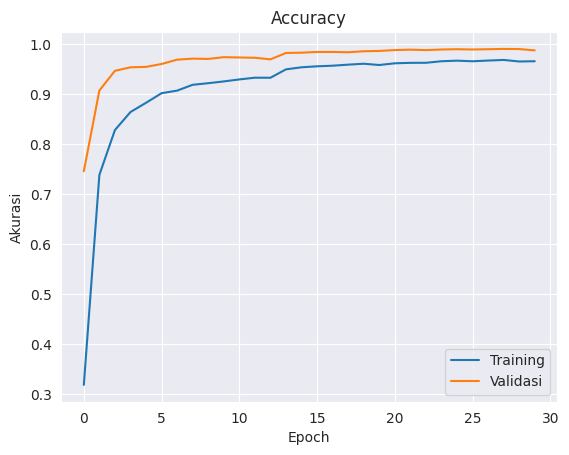

In [63]:
history.history.keys()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validasi'], loc='lower right')
plt.show()

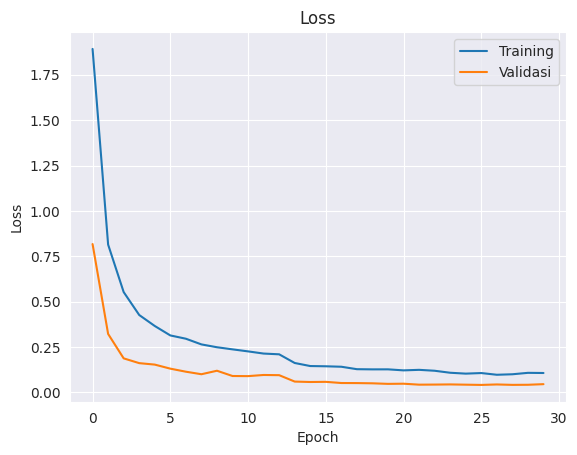

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validasi'], loc='upper right')

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
test_generator.reset()

y_pred = model.predict(test_generator,verbose=0)




              precision    recall  f1-score   support

           0  1.0000000000 0.9955257271 0.9977578475       447
           1  0.9977578475 0.9933035714 0.9955257271       448
           2  0.9866962306 0.9955257271 0.9910913140       447
           3  0.9733924612 0.9954648526 0.9843049327       441
           4  0.9976798144 0.9862385321 0.9919261822       436
           5  0.9837209302 0.9952941176 0.9894736842       425
           6  0.9905437352 0.9882075472 0.9893742621       424
           7  0.9905882353 0.9952718676 0.9929245283       423
           8  0.9733656174 0.9640287770 0.9686746988       417
           9  0.9848484848 0.9677419355 0.9762202753       403

    accuracy                      0.9879378334      4311
   macro avg  0.9878593357 0.9876602655 0.9877273452      4311
weighted avg  0.9879799048 0.9879378334 0.9879266042      4311



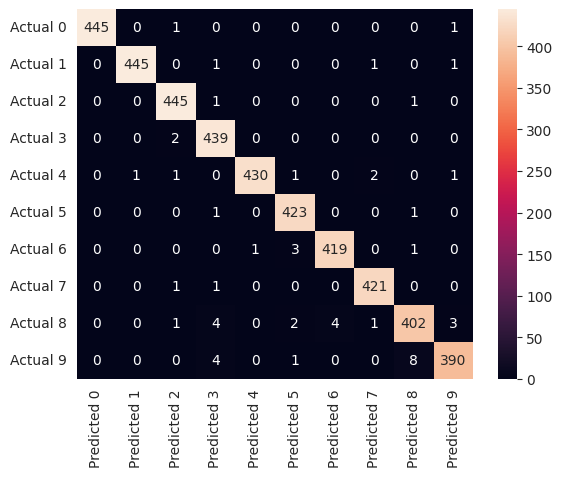

In [66]:
y_pred_classes = np.argmax(y_pred, axis=1)

cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, y_pred_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                  index=["Actual 0", "Actual 1", "Actual 2","Actual 3", "Actual 4", "Actual 5", "Actual 6", "Actual 7", "Actual 8", "Actual 9"],
                  columns=["Predicted 0", "Predicted 1", "Predicted 2","Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6", "Predicted 7", "Predicted 8", "Predicted 9"])
sns.heatmap(cm,annot=True,fmt="d")

print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=y_pred_classes, target_names =['0','1','2','3','4','5','6','7','8','9'], digits=10))

## Konversi Model

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
# load model if already train
# save our model
# format HDF5
MODEL_BASE_PATH='/content/drive/MyDrive/submission2/models/'
if not os.path.exists(MODEL_BASE_PATH):
  os.makedirs(MODEL_BASE_PATH)
try:
  model = tf.keras.models.load_model(f"{MODEL_BASE_PATH}model.keras")
except:
  model.save(f"{MODEL_BASE_PATH}model.keras")
  model.save(f"{MODEL_BASE_PATH}model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [70]:
# format savedmodel
saved_model_path = f"{MODEL_BASE_PATH}saved_model"
if not os.path.exists(saved_model_path):
  os.makedirs(saved_model_path)
tf.saved_model.save(model, f"{MODEL_BASE_PATH}saved_model")

In [71]:
# format tflite
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()
tflite_model_path = f"{MODEL_BASE_PATH}tflite/"
if not os.path.exists(tflite_model_path):
  os.makedirs(tflite_model_path)

tflite_model_file = pathlib.Path(f'{tflite_model_path}model.tflite')
tflite_model_file.write_bytes(tflite_model)

35786876

In [72]:
# tfjs
# Install tensorflowjs
!pip install tensorflowjs

  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.7 MB/s eta 0:00:00
Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 111.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
   

In [74]:
 # Convert model.h5 to model
import os
# os.system(f'tensorflowjs_converter --input_format=keras model.keras tfjs_model')
!tensorflowjs_converter --input_format=keras /content/drive/MyDrive/submission2/models/model.h5 /content/drive/MyDrive/submission2/models/tfjs_model

2024-08-08 08:39:06.157916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 08:39:06.199461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 08:39:06.199534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 08:39:07.743135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Inference (Optional)

#### Inference with tflite

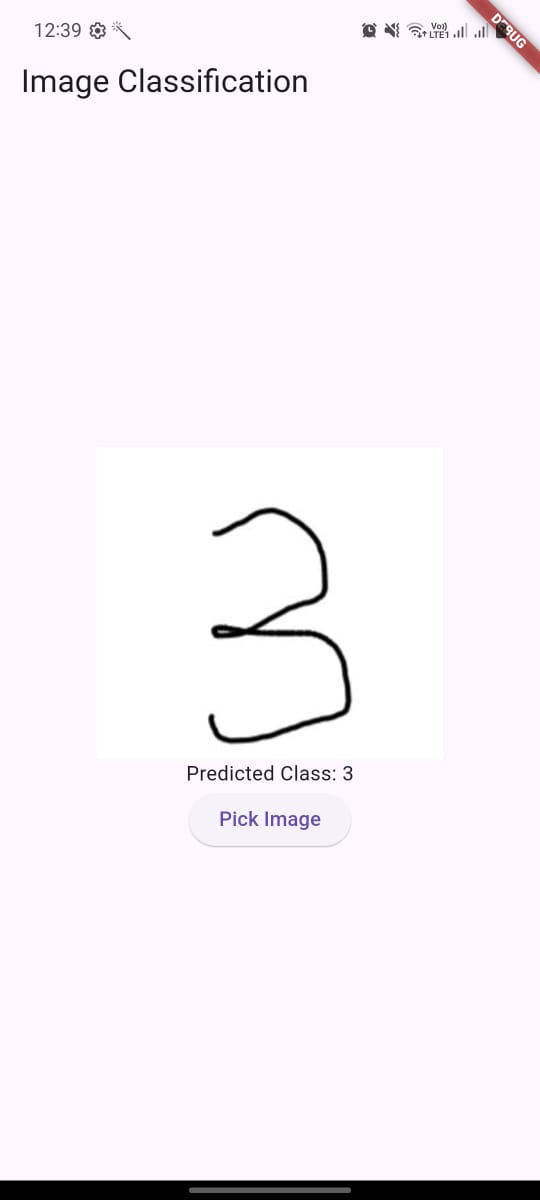

#### Inference with keras/h5 model

In [75]:
from tensorflow.keras.preprocessing import image
def load_and_preprocess_image(img_path, target_size=(90, 140), color_mode="grayscale"):
    """Load and preprocess the image."""
    img = image.load_img(img_path, target_size=target_size, color_mode=color_mode)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

def predict_image_class(model, img_paths, class_labels):
    """Predict the class of an input image using a trained model."""
    # Load and preprocess the image
    for img_path in img_paths:
      img_array = load_and_preprocess_image(img_path)

      # Perform prediction
      predictions = model.predict(img_array)
      predicted_class = np.argmax(predictions, axis=1)[0]

      predict_proba=sorted(predictions[0])[9]

      # Get the predicted class label
      predicted_class_label = class_labels[predicted_class]
      print("Probability: ", round(predict_proba*100,2), "%")

      # Plot the image and prediction result
      plt.imshow(image.load_img(img_path, target_size=(90, 140), color_mode="grayscale"), cmap="gray")
      plt.title(f"Predicted Class: {predicted_class_label}")
      plt.axis('off')
      plt.show()

      print(f"Predicted Class Label for {img_path}: {predicted_class_label}")

Saving Screenshot 2024-08-06 at 11.05.48 PM.png to Screenshot 2024-08-06 at 11.05.48 PM.png
Saving Screenshot 2024-08-06 at 11.16.38 PM.png to Screenshot 2024-08-06 at 11.16.38 PM.png
Saving Screenshot 2024-08-06 at 11.16.43 PM.png to Screenshot 2024-08-06 at 11.16.43 PM.png
Saving Screenshot 2024-08-06 at 11.16.50 PM.png to Screenshot 2024-08-06 at 11.16.50 PM.png
Saving Screenshot 2024-08-06 at 11.16.54 PM.png to Screenshot 2024-08-06 at 11.16.54 PM.png
Saving Screenshot 2024-08-06 at 11.16.58 PM.png to Screenshot 2024-08-06 at 11.16.58 PM.png
Saving Screenshot 2024-08-06 at 11.17.02 PM.png to Screenshot 2024-08-06 at 11.17.02 PM.png
Saving Screenshot 2024-08-06 at 11.17.07 PM.png to Screenshot 2024-08-06 at 11.17.07 PM.png
Saving Screenshot 2024-08-06 at 11.17.11 PM.png to Screenshot 2024-08-06 at 11.17.11 PM.png
1/1 [==============================] - 0s 120ms/step
Probability:  99.98 %


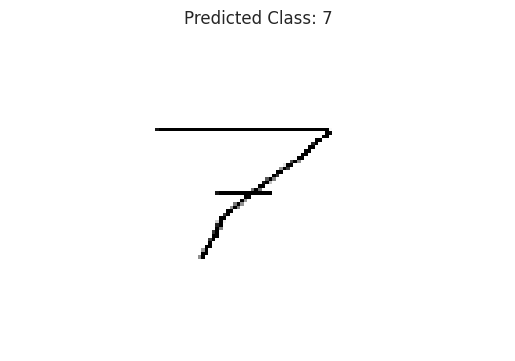

Predicted Class Label for Screenshot 2024-08-06 at 11.05.48 PM.png: 7
1/1 [==============================] - 0s 18ms/step
Probability:  99.84 %


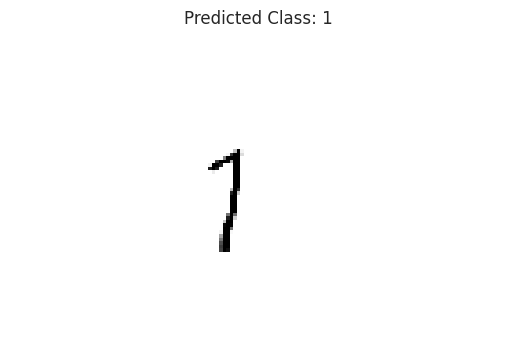

Predicted Class Label for Screenshot 2024-08-06 at 11.16.38 PM.png: 1
1/1 [==============================] - 0s 17ms/step
Probability:  99.89 %


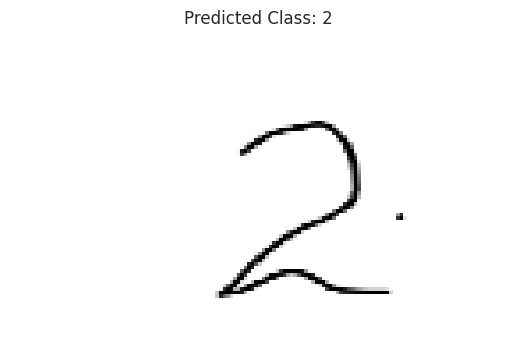

Predicted Class Label for Screenshot 2024-08-06 at 11.16.43 PM.png: 2
1/1 [==============================] - 0s 20ms/step
Probability:  99.99 %


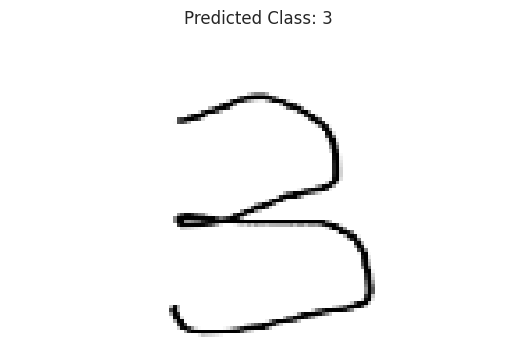

Predicted Class Label for Screenshot 2024-08-06 at 11.16.50 PM.png: 3
1/1 [==============================] - 0s 17ms/step
Probability:  100.0 %


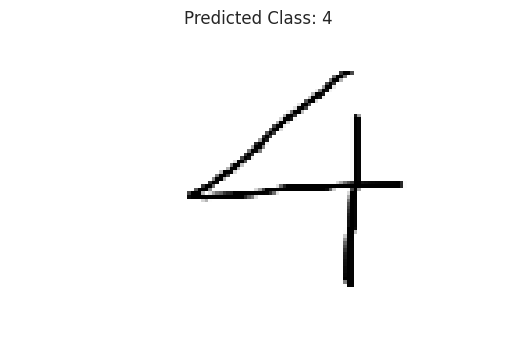

Predicted Class Label for Screenshot 2024-08-06 at 11.16.54 PM.png: 4
1/1 [==============================] - 0s 37ms/step
Probability:  100.0 %


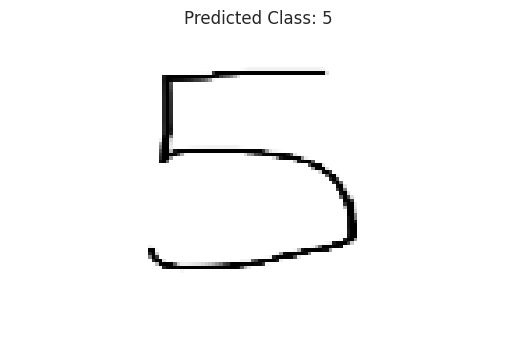

Predicted Class Label for Screenshot 2024-08-06 at 11.16.58 PM.png: 5
1/1 [==============================] - 0s 18ms/step
Probability:  93.02 %


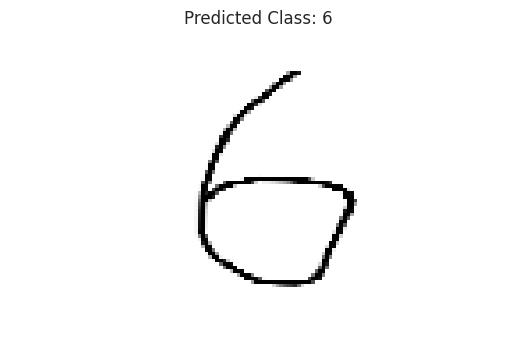

Predicted Class Label for Screenshot 2024-08-06 at 11.17.02 PM.png: 6
1/1 [==============================] - 0s 18ms/step
Probability:  62.53 %


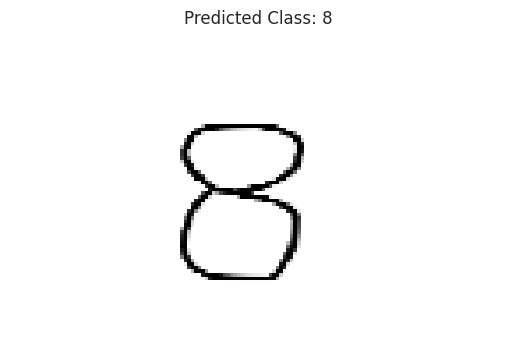

Predicted Class Label for Screenshot 2024-08-06 at 11.17.07 PM.png: 8
1/1 [==============================] - 0s 17ms/step
Probability:  81.61 %


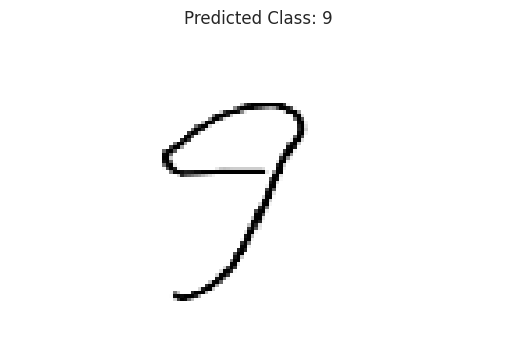

Predicted Class Label for Screenshot 2024-08-06 at 11.17.11 PM.png: 9


In [76]:
from google.colab import files
# Upload the image
uploaded = files.upload()
img_paths = list(uploaded.keys())

class_labels = [0,1,2,3,4,5,6,7,8,9]

# Predict the class of the uploaded image
predict_image_class(model, img_paths, class_labels)